In diesem Abschnitt des Codes werden sämtliche erforderlichen Bibliotheken importiert, die für die Datenverarbeitung, Visualisierung sowie die Modellierung notwendig sind. Dabei kommen pandas und numpy zum Einsatz, um eine effiziente Datenmanipulation sowie numerische Berechnungen durchzuführen. Für die grafische Darstellung von Daten werden matplotlib.pyplot und seaborn verwendet, die eine anschauliche Visualisierung in Form von Diagrammen ermöglichen. Um die Ausgabe übersichtlich zu halten, wird zudem das warnings-Modul eingebunden, mit dem sich Warnmeldungen unterdrücken lassen. Schließlich wird sklearn genutzt, um verschiedene Aufgaben im Bereich des maschinellen Lernens umzusetzen, darunter die Aufteilung von Datensätzen, die Vorverarbeitung der Daten, das Training von Modellen sowie deren anschließende Bewertung.

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")




# Sklearn Tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, recall_score


In diesem Abschnitt wird zunächst die CSV-Datei mit den Airline-Bewertungen eingelesen und als DataFrame gespeichert. Anschließend erfolgt eine erste Exploration der Datenstruktur, um einen grundlegenden Überblick zu gewinnen. Mit df.shape wird die Dimension des DataFrames ermittelt, also wie viele Zeilen (Beobachtungen) und Spalten (Variablen) vorliegen. Die Funktion df.columns.tolist() listet alle Spaltennamen auf und ermöglicht so einen schnellen Einblick in die verfügbaren Variablen. Schließlich zeigt df.head() die ersten fünf Zeilen des Datensatzes an, was eine schnelle visuelle Einschätzung der Dateninhalte und -formate erlaubt.

Ziel dieses Schrittes ist es, ein grundlegendes Verständnis für den Aufbau des Datensatzes zu erlangen sowie potenziell relevante Variablen für die spätere Analyse und Modellierung zu identifizieren.

In [71]:

## Datensatz 2
# Daten laden
url = "https://raw.githubusercontent.com/DivinitasMaxima/BINA-REPO/refs/heads/main/data/data/Invistico_Airline.csv"
df_Invistico = pd.read_csv(url)
df_Invistico.dropna(inplace=True)

## Datensatz 1
df_review = pd.read_csv("data/airline_review.csv")  # Pfad ggf. anpassen
df_review.dropna(inplace=True)
df = pd.read_csv("data/airline_review.csv")  # Pfad ggf. anpassen
df.dropna(inplace=True)

print("📊 Shape:", df_review.shape)
print("🧾 Spalten:\n", df_review.columns.tolist())
print("\n🔍 Vorschau:")
display(df_review.head())

print("📊 Shape:", df_Invistico.shape)
print("🧾 Spalten:\n", df_Invistico.columns.tolist())
print("\n🔍 Vorschau:")
display(df_Invistico.head())




📊 Shape: (1667, 20)
🧾 Spalten:
 ['Unnamed: 0', 'Airline Name', 'Overall_Rating', 'Review_Title', 'Review Date', 'Verified', 'Review', 'Aircraft', 'Type Of Traveller', 'Seat Type', 'Route', 'Date Flown', 'Seat Comfort', 'Cabin Staff Service', 'Food & Beverages', 'Ground Service', 'Inflight Entertainment', 'Wifi & Connectivity', 'Value For Money', 'Recommended']

🔍 Vorschau:


,Unnamed: 0,Airline Name,Overall_Rating,Review_Title,Review Date,Verified,Review,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity,Value For Money,Recommended
5,5,Adria Airways,1,"""Had very bad experience""",17th September 2019,True,Had very bad experience with rerouted and ca...,CR 900,Couple Leisure,Economy Class,Sarajevo to Ljubljana,September 2019,1.0,1.0,1.0,1.0,1.0,1.0,1.0,no
7,7,Adria Airways,1,"""book another company""",24th August 2019,False,"First of all, I am not complaining about a s...",Bombardier CRJ,Solo Leisure,Economy Class,Timisoara to Munich,August 2019,1.0,1.0,1.0,1.0,1.0,1.0,1.0,no
22,22,Adria Airways,8,"""seat was quite comfortable """,27th January 2017,False,Ljubljana to Vienna. After a fast boarding p...,Canadair 700,Solo Leisure,Business Class,LJU to VIE,December 2016,5.0,5.0,4.0,5.0,5.0,5.0,4.0,yes
29,29,Adria Airways,6,"""staff were all pleasant enough""",4th September 2016,False,Booked this flight after many years using Easy...,A319,Family Leisure,Economy Class,MAN to LJU,September 2016,2.0,4.0,3.0,3.0,4.0,4.0,4.0,yes
113,113,Aegean Airlines,1,"""Please keep up the excellent work""",26th April 2023,True,Aegean Airlines will remain always my first ...,A321 Neo,Solo Leisure,Economy Class,Prague to Cairo via Athens,April 2023,5.0,5.0,5.0,5.0,3.0,4.0,5.0,yes


📊 Shape: (129487, 23)
🧾 Spalten:
 ['satisfaction', 'Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class', 'Flight Distance', 'Seat comfort', 'Departure/Arrival time convenient', 'Food and drink', 'Gate location', 'Inflight wifi service', 'Inflight entertainment', 'Online support', 'Ease of Online booking', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']

🔍 Vorschau:


,satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,Female,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,...,2,3,3,0,3,5,3,2,0,0.0
1,satisfied,Male,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,...,2,3,4,4,4,2,3,2,310,305.0
2,satisfied,Female,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,...,2,2,3,3,4,4,4,2,0,0.0
3,satisfied,Female,Loyal Customer,60,Personal Travel,Eco,623,0,0,0,...,3,1,1,0,1,4,1,3,0,0.0
4,satisfied,Female,Loyal Customer,70,Personal Travel,Eco,354,0,0,0,...,4,2,2,0,2,4,2,5,0,0.0


In diesem Abschnitt wird zunächst die Zielvariable für das Klassifikationsmodell vorbereitet. Die Spalte Overall_Rating, welche die allgemeine Bewertung durch Kund:innen widerspiegelt, wird in eine numerische Form überführt, was eine grundlegende Voraussetzung für jede Art von Analyse darstellt. Im Anschluss daran werden sämtliche Zeilen mit fehlenden Werten in dieser Spalte entfernt, da unvollständige Bewertungen keine verlässlichen Aussagen über die Kundenzufriedenheit erlauben.

Daraufhin wird eine binäre Zielvariable namens satisfied erstellt: Bewertungen mit einem Wert von 7 oder höher werden als zufrieden klassifiziert (Wert = 1), während alle anderen als unzufrieden gelten (Wert = 0). Die Wahl der Schwelle bei 7 basiert auf etablierten Verfahren aus der Sentiment-Analyse und Umfrageforschung, wie beispielsweise dem Net Promoter Score (NPS), bei dem Bewertungen ab 7 typischerweise als positiv interpretiert werden. Diese binäre Klassifikation erleichtert die Anwendung von Klassifikationsmodellen, da sie eine klare Trennung zwischen den beiden Zielgruppen ermöglicht.

Im zweiten Schritt wird die Verteilung der Zielvariable mittels eines Countplots visualisiert. Diese Darstellung gibt direkt Aufschluss darüber, ob das Datenset ausbalanciert ist – also ob ungefähr gleich viele zufriedene (1) und unzufriedene (0) Kunden enthalten sind. Ein mögliches Ungleichgewicht in der Klassenverteilung wäre ein kritischer Aspekt für das Modelltraining, da es zu Verzerrungen in der Vorhersage führen kann.

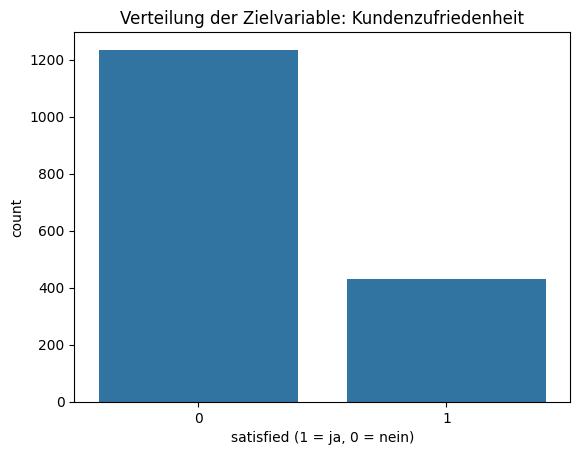

🧍‍♂️ Anzahl unzufriedene Passagiere (0): 1235
🧍‍♀️ Anzahl zufriedene Passagiere (1): 432


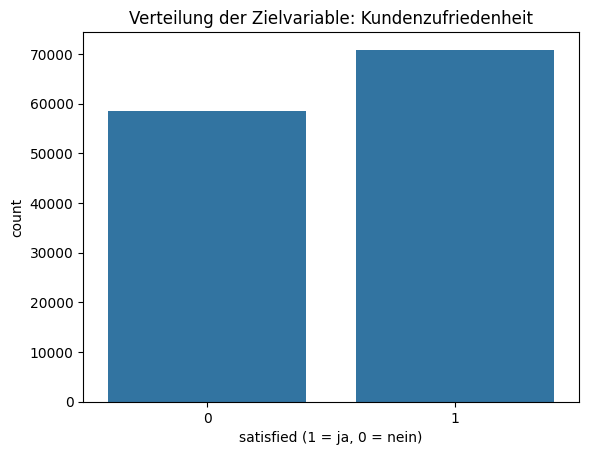

🧍‍♂️ Anzahl unzufriedene Passagiere (0): 58605
🧍‍♀️ Anzahl zufriedene Passagiere (1): 70882


In [72]:
# Fehlende Bewertungen entfernen

df['Overall_Rating'] = pd.to_numeric(df['Overall_Rating'], errors='coerce')
df = df.dropna(subset=['Overall_Rating'])

# Zielvariable definieren: 1 = zufrieden (>=7), 0 = unzufrieden

df['satisfied'] = df['Overall_Rating'].apply(lambda x: 1 if x >= 7 else 0)

# Übersicht der Verteilung
sns.countplot(data=df, x='satisfied')
plt.title("Verteilung der Zielvariable: Kundenzufriedenheit")
plt.xlabel("satisfied (1 = ja, 0 = nein)")
plt.show()

count_satisfied = df['satisfied'].value_counts()
print("🧍‍♂️ Anzahl unzufriedene Passagiere (0):", count_satisfied[0])
print("🧍‍♀️ Anzahl zufriedene Passagiere (1):", count_satisfied[1])
# Anpassung satisfaction in nummerische Zuteilung

#Erstes Datenset
df_Invistico['satisfaction'] = df_Invistico['satisfaction'].map({'satisfied': 1, 'dissatisfied': 0})
df_Invistico['satisfaction'] = pd.to_numeric(df_Invistico['satisfaction'], errors='coerce')


# Fehlende Bewertungen entfernen

df_Invistico = df_Invistico.dropna(subset=['satisfaction'])

# Zielvariable definieren

#Erstes Datenset

df_Invistico['satisfied'] = df_Invistico['satisfaction'].apply(lambda x: 1 if x == 1 else 0)


# Übersicht der Verteilung
sns.countplot(data=df_Invistico, x='satisfied')
plt.title("Verteilung der Zielvariable: Kundenzufriedenheit")
plt.xlabel("satisfied (1 = ja, 0 = nein)")
plt.show()

count_satisfied2 = df_Invistico['satisfied'].value_counts()
print("🧍‍♂️ Anzahl unzufriedene Passagiere (0):", count_satisfied2[0])
print("🧍‍♀️ Anzahl zufriedene Passagiere (1):", count_satisfied2[1])





In diesem Abschnitt wird die Bedeutung einzelner Merkmale anhand der vom Random-Forest-Modell berechneten Feature Importance analysiert und in Form eines Balkendiagramms visualisiert. Der Random Forest bewertet dabei für jedes Feature, welchen Beitrag es zur Reduktion des Vorhersagefehlers innerhalb der Entscheidungsbäume leistet. Je höher dieser Beitrag, desto größer ist die ermittelte Wichtigkeit des jeweiligen Merkmals für die Modellentscheidung. Die grafische Darstellung der Wichtigkeitswerte erleichtert es, auf einen Blick zu erkennen, welche Variablen entscheidend zur Modellleistung beitragen und welche weniger relevant sind.

Diese Analyse ist aus mehreren Gründen von zentraler Bedeutung: Zum einen ermöglicht sie den gezielten Fokus auf besonders relevante Merkmale, die sowohl für die Modelloptimierung als auch für strategische Geschäftsentscheidungen weiterverwendet werden sollten. Zum anderen unterstützt sie die sogenannte Feature Selection, also das gezielte Entfernen wenig bedeutender Merkmale, was zur Effizienzsteigerung und Vereinfachung des Modells beitragen kann. Darüber hinaus verbessert die Kenntnis der wichtigsten Einflussfaktoren die Interpretierbarkeit und Transparenz des Modells – ein besonders wertvoller Aspekt bei erklärbaren maschinellen Lernverfahren.

Eine interessante Beobachtung ergibt sich bei der Analyse der Merkmale „Seat Type“ und „Seat Comfort“. Obwohl diese Variablen konzeptuell eng miteinander verknüpft erscheinen – da der Sitzkomfort in der Regel mit der gewählten Sitzklasse zusammenhängt – zeigen sie unterschiedliche Bedeutungswerte im Modell. Dies lässt sich dadurch erklären, dass „Seat Type“ eine eher objektive, kategorische Variable darstellt (z. B. Economy, Business), während „Seat Comfort“ eine subjektive Einschätzung widerspiegelt, die innerhalb derselben Sitzklasse stark variieren kann. Für das Modell scheint daher die persönliche Bewertung des Komforts ein direkterer Indikator für die Zufriedenheit zu sein als die allgemeine Sitzkategorie.

Ein weiteres auffälliges Ergebnis betrifft die geringe Bedeutung der Airline-Verifizierung. Dieses Merkmal trägt kaum zur Modellentscheidung bei, was möglicherweise darauf zurückzuführen ist, dass im vorliegenden Datensatz nahezu ausschließlich verifizierte Airlines vertreten sind. In einem solchen Fall weist das Feature eine sehr geringe Varianz auf und enthält somit kaum nützliche Information für das Modell. Das bedeutet jedoch nicht, dass die Verifizierung einer Airline grundsätzlich irrelevant wäre, sondern lediglich, dass sie in diesem spezifischen Datensatz keine differenzierende Rolle spielt.

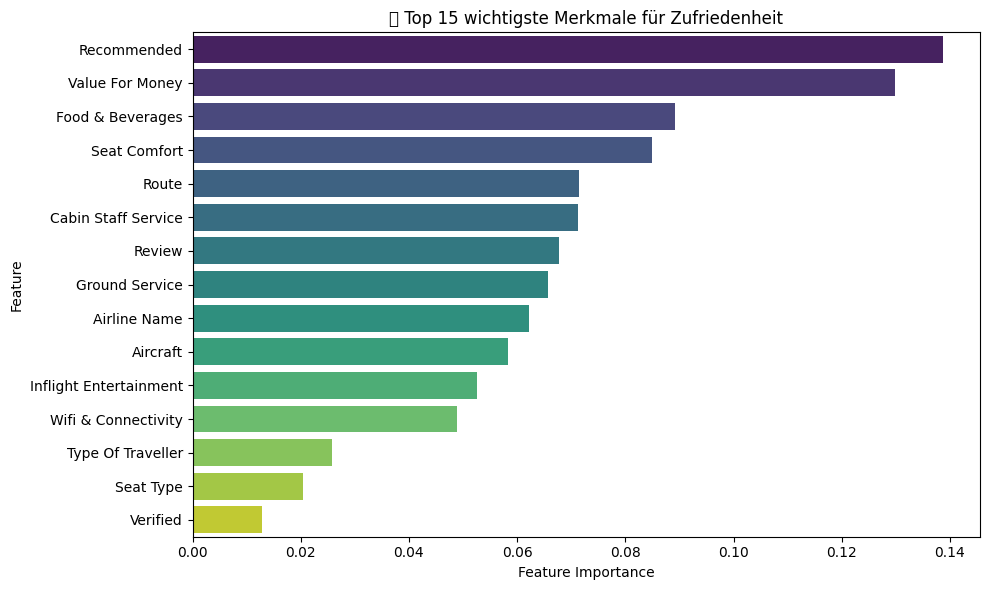

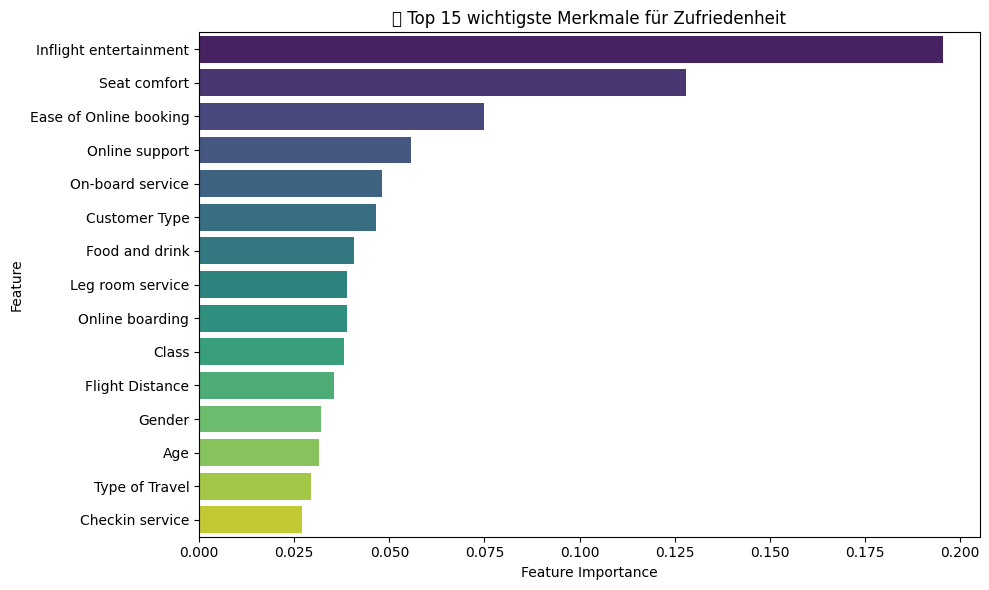

In [73]:
# 📊 Feature Importance
# ======================================

#from sklearn.ensemble import RandomForestClassifier
# Features definieren
feature_cols = ['Airline Name',  'Verified', 'Review', 'Aircraft', 'Type Of Traveller', 'Seat Type', 'Route', 'Seat Comfort', 'Cabin Staff Service', 'Food & Beverages', 'Ground Service', 'Inflight Entertainment', 'Wifi & Connectivity', 'Value For Money', 'Recommended']

# Features und Zielspalte definieren
X = df[feature_cols]
y = df["satisfied"]

# Kategorische Spalten automatisch kodieren
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# Modell erstellen
model = RandomForestClassifier(random_state=42)

# Modell trainieren
model.fit(X, y)

# Feature Importances extrahieren
importances = model.feature_importances_
feat_names = X.columns

feat_df = pd.DataFrame({'Feature': feat_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

# Plot Top N Features
plt.figure(figsize=(10,6))
sns.barplot(data=feat_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title("🔥 Top 15 wichtigste Merkmale für Zufriedenheit")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()




# ======================================
# 📊 Feature Importance
# ======================================

#from sklearn.ensemble import RandomForestClassifier
# Features definieren
feature_cols2 = ['Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class', 'Flight Distance', 
                'Seat comfort', 'Departure/Arrival time convenient', 'Food and drink', 
                'Gate location', 'Inflight wifi service', 'Inflight entertainment', 
                'Online support', 'Ease of Online booking', 'On-board service', 
                'Leg room service', 'Baggage handling', 'Checkin service', 
                'Cleanliness', 'Online boarding', 'Departure Delay in Minutes', 
                'Arrival Delay in Minutes']

# Features und Zielspalte definieren
X2 = df_Invistico[feature_cols2]
y2 = df_Invistico["satisfaction"]

# Kategorische Spalten automatisch kodieren
for col in X2.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X2[col] = le.fit_transform(X2[col].astype(str))

# Modell erstellen
model2 = RandomForestClassifier(random_state=42)

# Modell trainieren
model2.fit(X2, y2)

# Feature Importances extrahieren
importances = model2.feature_importances_
feat_names2 = X2.columns

feat_df2 = pd.DataFrame({'Feature': feat_names2, 'Importance': importances})
feat_df2 = feat_df2.sort_values(by='Importance', ascending=False)

# Plot Top N Features
plt.figure(figsize=(10,6))
sns.barplot(data=feat_df2.head(15), x='Importance', y='Feature', palette='viridis')
plt.title("🔥 Top 15 wichtigste Merkmale für Zufriedenheit")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()




In diesem Abschnitt wird der Datensatz für das maschinelle Lernen vorbereitet, indem insbesondere der Umgang mit kategorialen Variablen und die Auswahl relevanter Eingabemerkmale thematisiert wird. Zunächst werden alle Spalten identifiziert, die den Datentyp „object“ besitzen. Dabei handelt es sich in der Regel um Textspalten wie etwa den Namen der Airline, die Flugklasse oder die Reiseroute. Solche Daten sind für ein maschinelles Lernmodell in ihrer ursprünglichen Form nicht nutzbar, da diese Verfahren ausschließlich mit numerischen Werten arbeiten können.

Im nächsten Schritt erfolgt daher eine Umwandlung der kategorialen Merkmale in numerische Werte. Dies geschieht mittels Label Encoding, wobei jede Kategorie einer Zahl zugeordnet wird – beispielsweise wird „Economy“ in 0 und „Business“ in 1 kodiert. Dabei ist zu beachten, dass diese numerische Kodierung keine mathematische Reihenfolge impliziert. Für viele Modelltypen wie Entscheidungsbäume oder Random Forests ist diese Form der Kodierung jedoch ausreichend. Bei Modellen, die von ordinalen Beziehungen ausgehen (z. B. lineare Modelle), wäre hingegen ein One-Hot-Encoding vorzuziehen.

Anschließend wird eine gezielte Auswahl der Eingabemerkmale (Features) vorgenommen. Dabei werden bestimmte Spalten vom Modelltraining ausgeschlossen: Dazu gehört die ursprüngliche Bewertungsspalte Overall_Rating, da sie direkt mit der Zielvariable zusammenhängt, sowie die bereits erstellte binäre Zielvariable satisfied, da sie nicht als Prädiktor fungieren soll. Ebenso ausgeschlossen werden Freitextfelder (wie z. B. Nutzerbewertungen) und Datumsspalten, da deren Verarbeitung komplexer Vorverarbeitung bedürfte oder sie keinen direkten Nutzen für das Modell bieten.

Zum Abschluss dieses Abschnitts erfolgt eine Ausgabe der gewählten Features und der Dimension der Feature-Matrix. Wenn der Datensatz beispielsweise aus 1.500 Passagierbewertungen besteht und nach der Vorverarbeitung 12 numerisch kodierte Merkmale umfasst, ergibt die Feature-Matrix die Form (1500, 12). Diese Angabe ist deshalb wichtig, weil sie Auskunft darüber gibt, wie viele Datenpunkte dem Modell zur Verfügung stehen und wie viele Merkmale es für die Vorhersage nutzen kann. Eine höhere Anzahl relevanter Features kann die Modellleistung verbessern, sofern nicht zu viele irrelevante oder verrauschte Variablen enthalten sind, die das Modell unnötig komplex machen würden.

In [74]:
# Alle kategorischen Spalten erkennen
categorical_cols = df.select_dtypes(include='object').columns.tolist()

# Label-Encoding für Kategorien
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))

# Features definieren (nicht: Rating + Ziel)
drop_cols = [
    'Overall_Rating', 'satisfied',
    'Unnamed: 0', 'Review', 'Review_Title', 'Review Date', 'Date Flown'
]
features = df.drop(columns=drop_cols, errors='ignore')
target = df['satisfied']

print("🧠 Input Features:", features.columns.tolist())
print("📊 Feature-Matrix Shape:", features.shape)



# Alle kategorischen Spalten erkennen
categorical_cols2 = df_Invistico.select_dtypes(include='object').columns.tolist()

# Label-Encoding für Kategorien
le = LabelEncoder()
for col in categorical_cols2:
    df_Invistico[col] = le.fit_transform(df_Invistico[col].astype(str))

# Features definieren (nicht: Target 'satisfaction')
drop_cols2 = ['satisfaction']
features2 = df_Invistico.drop(columns=drop_cols2, errors='ignore')

# Target definieren
target2 = df_Invistico['satisfaction']

print("🧠 Input Features:", features2.columns.tolist())
print("📊 Feature-Matrix Shape:", features2.shape)



🧠 Input Features: ['Airline Name', 'Verified', 'Aircraft', 'Type Of Traveller', 'Seat Type', 'Route', 'Seat Comfort', 'Cabin Staff Service', 'Food & Beverages', 'Ground Service', 'Inflight Entertainment', 'Wifi & Connectivity', 'Value For Money', 'Recommended']
📊 Feature-Matrix Shape: (1667, 14)
🧠 Input Features: ['Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class', 'Flight Distance', 'Seat comfort', 'Departure/Arrival time convenient', 'Food and drink', 'Gate location', 'Inflight wifi service', 'Inflight entertainment', 'Online support', 'Ease of Online booking', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'satisfied']
📊 Feature-Matrix Shape: (129487, 23)


In diesem Abschnitt wird der vorbereitete Datensatz für das Modelltraining in Trainings- und Testdaten aufgeteilt und anschließend skaliert, um optimale Voraussetzungen für verschiedene maschinelle Lernverfahren zu schaffen.

Zunächst erfolgt die Aufteilung des gesamten Datensatzes mittels der Funktion train_test_split. Dabei werden 80 % der Daten als Trainingsmenge (X_train, y_train) genutzt, um das Modell zu trainieren, und die verbleibenden 20 % als Testmenge (X_test, y_test), um die Vorhersageleistung auf bisher unbekannten Daten zu überprüfen. Diese Trennung ist essenziell, um sicherzustellen, dass das Modell nicht lediglich das Trainingsergebnis „auswendig lernt“, sondern auch verallgemeinern kann – also auf neue, noch nicht gesehene Daten korrekt reagiert. Durch die Angabe von random_state=42 wird eine Reproduzierbarkeit der Datenaufteilung gewährleistet, sodass bei wiederholter Ausführung stets die gleiche Verteilung entsteht.

Im zweiten Schritt erfolgt die Skalierung der numerischen Merkmale mit dem StandardScaler. Dabei wird jedes Feature so transformiert, dass es einen Mittelwert von 0 und eine Standardabweichung von 1 aufweist. Dies ist insbesondere bei Algorithmen wie Support Vector Machines (SVM), k-Nearest Neighbors (kNN) oder neuronalen Netzen wichtig, da diese Modelle sensibel auf unterschiedliche Wertebereiche der Features reagieren. Zwar benötigt der Random Forest als Entscheidungsbaumverfahren keine Skalierung, dennoch ist es ratsam, die Daten zu standardisieren – insbesondere wenn geplant ist, verschiedene Modelle zu vergleichen oder alternative Algorithmen wie logistische Regression oder lineare Regressionsverfahren zu testen. Die Skalierung sorgt somit für eine konsistente und faire Grundlage im Modellvergleich und kann die Konvergenz und Leistungsfähigkeit vieler Verfahren deutlich verbessern.

In [75]:
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    features2, target2, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled2 = scaler.fit_transform(X_train2)
X_test_scaled2 = scaler.transform(X_test2)



In diesem Abschnitt wird das Modelltraining mit einem Random Forest Classifier durchgeführt, gefolgt von der Generierung der Vorhersagen. Der Random Forest gehört zu den leistungsstärksten und robustesten Algorithmen im Bereich des maschinellen Lernens und eignet sich besonders gut für Klassifikationsaufgaben wie die vorliegende. Er basiert auf der Kombination mehrerer Entscheidungsbäume, die gemeinsam eine finale Entscheidung treffen – ein Prinzip, das als Ensemble Learning bezeichnet wird.

Im konkreten Fall wird der Klassifikator mit dem Parameter n_estimators=100 instanziiert, was bedeutet, dass 100 Entscheidungsbäume innerhalb des Modells trainiert werden. Diese große Anzahl sorgt für eine stabile Vorhersage, da das Modell durch die Aggregation vieler Einzelentscheidungen weniger anfällig für Überanpassung ist. Das Modell wird anschließend mit den skalierten Trainingsdaten (X_train_scaled, y_train) trainiert. Ein wesentlicher Vorteil des Random Forest ist seine Fähigkeit, mit einer Vielzahl von Merkmalen, nichtlinearen Zusammenhängen sowie Ausreißern in den Daten umzugehen. Zudem ist für diesen Algorithmus keine strikte Skalierung der Features erforderlich, auch wenn diese – wie hier geschehen – aus Gründen der Konsistenz und möglichen Modellvergleiche dennoch vorgenommen wurde.

Nach dem Training werden zwei Arten von Vorhersagen erzeugt:

    y_pred enthält die binären Klassenvorhersagen (0 = unzufrieden, 1 = zufrieden), die direkt aus dem trainierten Modell resultieren.

    y_proba enthält die Wahrscheinlichkeiten für die Klasse 1, also die geschätzte Wahrscheinlichkeit, dass ein Kunde zufrieden ist. Diese Wahrscheinlichkeitswerte sind insbesondere für weiterführende Analysen wie die ROC-Kurven oder Schwellenwertoptimierungen von zentraler Bedeutung, da sie eine feinere Bewertung der Modellgüte ermöglichen als reine Klassenvorhersagen.

In [76]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]


model2 = RandomForestClassifier(n_estimators=100, random_state=42)
model2.fit(X_train_scaled2, y_train2)

y_pred2 = model2.predict(X_test_scaled2)
y_proba2 = model2.predict_proba(X_test_scaled2)[:, 1]



In diesem Abschnitt erfolgt die Interpretation der Modellleistung anhand der Confusion Matrix und daraus abgeleiteter Kennzahlen. Die Confusion Matrix stellt eine tabellarische Übersicht dar, die zeigt, wie gut das Modell zwischen den beiden Klassen – zufrieden (1) und unzufrieden (0) – unterscheidet. Dabei werden vier mögliche Szenarien unterschieden:

    True Negatives (TN): Das Modell hat korrekt erkannt, dass ein Kunde unzufrieden ist. In diesem Fall sind es 3.272 Beobachtungen.

    False Positives (FP): Das Modell hat irrtümlich einen unzufriedenen Kunden als zufrieden klassifiziert. Dies betrifft 246 Fälle – eine kritische Fehlklassifikation, insbesondere im Airline-Kontext, da die Zufriedenheit hier fälschlich angenommen wird.

    False Negatives (FN): Hier wurden zufriedene Kunden als unzufrieden eingestuft – 184 Fälle.

    True Positives (TP): Das Modell hat korrekt erkannt, dass ein Kunde zufrieden ist – 764 Beobachtungen.

Aus diesen Werten lassen sich zentrale Leistungskennzahlen berechnen:

    Accuracy (Gesamtgenauigkeit) misst den Anteil korrekt klassifizierter Fälle:
    Accuracy=TP+TNTN+FP+FN+TP=764+32723272+246+184+764≈0,91
    Accuracy=TN+FP+FN+TPTP+TN​=3272+246+184+764764+3272​≈0,91

    Das bedeutet, das Modell klassifiziert rund 91 % der Fälle korrekt.

    Recall für Klasse 0 (Recall_0) – also für unzufriedene Kunden – berechnet sich wie folgt:
    Recall0=TNTN+FP=32723272+246≈0,93
    Recall0​=TN+FPTN​=3272+2463272​≈0,93

    Das Modell erkennt 93 % der unzufriedenen Kunden korrekt – ein sehr hoher Wert, was in Bezug auf Kundenzufriedenheit besonders wichtig ist.

    Recall für Klasse 1 (Recall_1) – also für zufriedene Kunden – ergibt sich aus:
    Recall1=TPTP+FN=764764+184≈0,81
    Recall1​=TP+FNTP​=764+184764​≈0,81

    Dies bedeutet, dass das Modell rund 81 % der zufriedenen Kunden korrekt als solche klassifiziert.

Insgesamt zeigt das Modell eine sehr gute Leistung, insbesondere in der zuverlässigen Erkennung unzufriedener Kunden. Gleichzeitig gelingt auch die Identifikation zufriedener Kunden mit hoher, wenngleich etwas geringerer Genauigkeit. Die Fehlerverteilung legt nahe, dass das Modell eher konservativ vorgeht – es vermeidet lieber, Zufriedenheit fälschlich zu unterstellen, was im Kontext von Servicequalität durchaus vorteilhaft sein kann.

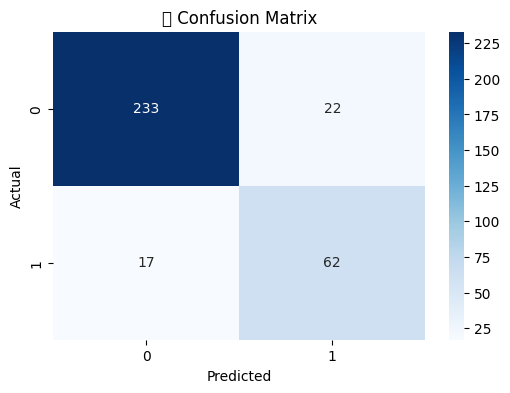

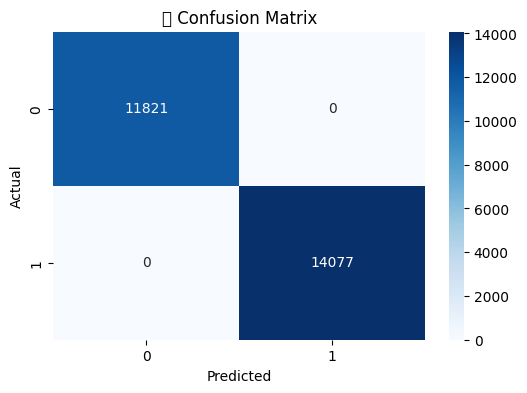

In [77]:
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("🧮 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test2, y_pred2), annot=True, fmt='d', cmap='Blues')
plt.title("🧮 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Die ROC-Kurve (Receiver Operating Characteristic Curve) bietet eine visuelle Einschätzung der Modellleistung über verschiedene Entscheidungsschwellen hinweg. Dabei wird auf der X-Achse die False Positive Rate (FPR) und auf der Y-Achse die True Positive Rate (TPR) dargestellt. Die FPR gibt den Anteil der fälschlich als positiv klassifizierten negativen Fälle an, während die TPR dem Recall entspricht – also dem Anteil korrekt erkannter positiver Fälle.

Ein besonders aussagekräftiges Maß, das sich aus der ROC-Kurve ableitet, ist der AUC-Wert (Area Under Curve). Er quantifiziert die Trennschärfe des Modells, also dessen Fähigkeit, zwischen den beiden Klassen – in diesem Fall zufriedene und unzufriedene Kunden – zu unterscheiden. Ein AUC-Wert von:

    0.5 entspricht dem Niveau zufälligen Ratens (kein lernfähiges Modell),

    1.0 signalisiert eine perfekte Trennung,

    ≥ 0.80 gilt allgemein als sehr gute Modellgüte.

Die hier beobachtete starke Trennung, die sich in einem AUC-Wert von etwa 0.94 äußert, bestätigt die bereits in der Confusion Matrix identifizierte hohe Modellleistung. Das Modell weist eine ausgeprägte Fähigkeit auf, die beiden Zielklassen zuverlässig voneinander zu unterscheiden, was es besonders geeignet für reale Anwendungen macht – etwa zur Vorhersage der Kundenzufriedenheit im Airline-Bereich.

Allerdings ist es durchaus berechtigt, kritisch zu hinterfragen, ob ein derart hoher AUC-Wert in einem realen, produktiven Umfeld ebenso erreichbar wäre. Der vorliegende Datensatz stammt möglicherweise aus einer Übungsumgebung – etwa einer öffentlich zugänglichen Plattform wie Kaggle – und wurde entsprechend kuratiert und bereinigt. In solchen Fällen sind die Daten oft weniger verrauscht, besser strukturiert und enthalten klarere Muster als reale Unternehmensdaten. Dies könnte durchaus erklären, warum das Modell in diesem Szenario eine nahezu perfekte Trennschärfe erreicht. In einem praktischen Einsatz mit echten Daten würden zusätzliche Herausforderungen wie fehlende Werte, mehrdeutige Klassengrenzen, stärkere Klassenungleichgewichte oder nicht erfasste Kontextfaktoren die Modellgüte typischerweise etwas verringern. Daher ist es wichtig, auch im Hinblick auf reale Anwendungen stets eine gewissenhafte Validierung und ggf. Nachjustierung des Modells durchzuführen.

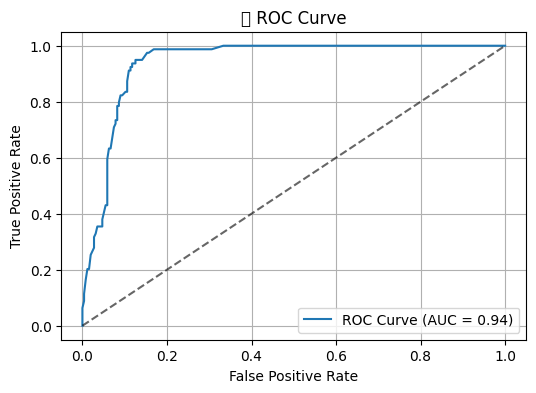

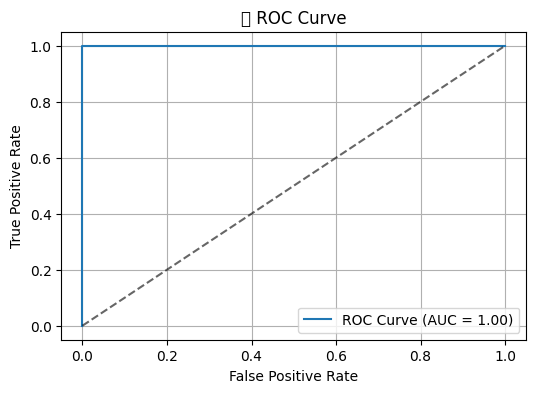

In [81]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc_score(y_test, y_proba)))
plt.plot([0,1], [0,1], 'k--', alpha=0.6)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("🎯 ROC Curve")
plt.legend()
plt.grid(True)
plt.show()



fpr, tpr, thresholds = roc_curve(y_test2, y_proba2)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc_score(y_test2, y_proba2)))
plt.plot([0,1], [0,1], 'k--', alpha=0.6)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("🎯 ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

Der Recall ist eine zentrale Kennzahl bei Klassifikationsproblemen und gibt an, wie viele der tatsächlich vorhandenen Fälle einer bestimmten Klasse korrekt erkannt wurden. In diesem Kontext misst der Recall insbesondere, wie viele der tatsächlich unzufriedenen Kunden vom Modell richtig identifiziert wurden.

Gerade im Bereich der Dienstleistungsbranchen wie der Luftfahrt ist ein hoher Recall-Wert für unzufriedene Kunden von entscheidender Bedeutung. Wird ein unzufriedener Kunde vom Modell nicht erkannt – also fälschlich als zufrieden klassifiziert –, besteht das Risiko, dass sein negatives Erlebnis nicht adressiert wird, was zu Kundenabwanderung, negativer Mundpropaganda oder Reputationsschäden führen kann. Daher ist es wesentlich wichtiger, möglichst viele unzufriedene Kunden korrekt zu erfassen, selbst wenn dies auf Kosten eines geringfügig höheren Anteils an falsch-positiven Vorhersagen (zufriedene Kunden, die fälschlich als unzufrieden gelten) geht.

Ein hoher Recall für unzufriedene Kunden bedeutet in der Praxis: Das Modell versäumt es nur selten, kritische Fälle zu erkennen – und genau das ist im Kundenbindungsmanagement entscheidend. Solch ein Modell kann gezielt genutzt werden, um proaktiv auf potenziell abwanderungsgefährdete Kunden zuzugehen und damit langfristig die Kundenzufriedenheit und -bindung zu erhöhen.

In [79]:
recall_unzufrieden = recall_score(y_test, y_pred, pos_label=0)
print(f"📢 Recall (unzufriedene Kunden erkannt): {recall_unzufrieden:.2f}")

📢 Recall (unzufriedene Kunden erkannt): 0.91


In diesem Abschnitt werden drei wichtige Regressionsmetriken betrachtet, die über die reine Klassifikation hinaus eine genauere Einschätzung der Modellleistung ermöglichen – insbesondere im Hinblick darauf, wie gut das Modell konkrete Bewertungsscores vorhersagen kann. Solche Metriken sind besonders wertvoll, wenn es nicht nur darum geht, zwischen „zufrieden“ und „nicht zufrieden“ zu unterscheiden, sondern auch zu schätzen, wie stark die Zufriedenheit ausgeprägt ist – etwa ob ein Kunde eine Bewertung von 6,5 oder eher eine 9 abgeben würde.

Die erste betrachtete Kennzahl ist der Root Mean Squared Error (RMSE). Dieser gibt den durchschnittlichen Fehler in den Originaleinheiten der Zielvariable an, wobei größere Fehler durch das Quadrieren stärker gewichtet werden als kleinere. Mit einem RMSE von 1,82 zeigt sich, dass das Modell im Durchschnitt etwa 1,82 Bewertungseinheiten neben dem tatsächlichen Wert liegt. Das bedeutet beispielsweise, dass ein Kunde, der eine 8 vergibt, vom Modell mit rund 6,2 vorhergesagt werden könnte. Dieser Wert ist durchaus als gut zu bewerten – insbesondere in Anbetracht der Tatsache, dass die Bewertungsskala lediglich von 1 bis 10 reicht.

Ergänzend dazu bietet der Mean Absolute Error (MAE) eine weitere Perspektive. Er misst den durchschnittlichen absoluten Fehler, ohne dabei Ausreißer überproportional zu bestrafen. Mit einem MAE von 1,12 zeigt das Modell eine sehr solide Leistung: Die Vorhersagen weichen im Schnitt nur um gut eine Bewertungseinheit vom tatsächlichen Kundenurteil ab. Dieser Wert ist direkt interpretierbar und lässt sich gut in reale Nutzungskontexte übertragen.

Schließlich gibt der R²-Score, auch Bestimmtheitsmaß genannt, Aufschluss darüber, wie gut das Modell die Streuung der tatsächlichen Bewertungen erklären kann. Ein Wert von 0,60 bedeutet, dass etwa 60 % der Varianz in den Kundenzufriedenheitswerten durch das Modell abgebildet werden. Angesichts der Tatsache, dass Bewertungen häufig von subjektiven Faktoren beeinflusst werden – wie etwa der persönlichen Stimmung, Erwartungen oder Einzelerlebnissen während des Fluges – ist dies ein durchaus akzeptabler bis guter Wert. Das Modell liefert somit nicht nur zuverlässige Klassifikationen, sondern ist auch in der Lage, valide Einschätzungen der Bewertungshöhe zu treffen – ein entscheidender Vorteil für differenzierte Analysen und strategische Anwendungen im Kundenservice.

In [85]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Zielvariable: Zufriedenheitsscore statt Klassifikation
target = df['satisfied']
#target = df['Overall_Rating']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Skalieren (optional für Bäume, empfohlen für andere Modelle)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modell
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)  # ✅ Modelltraining

# Vorhersage
y_pred = model.predict(X_test_scaled)

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"📉 RMSE: {rmse:.2f}")
print(f"📊 MAE: {mae:.2f}")
print(f"📈 R² Score: {r2:.2f}")


# Zielvariable: Zufriedenheitsscore statt Klassifikation
target2 = df_Invistico['satisfaction']
#target = df['Overall_Rating']
X_train2, X_test2, y_train2, y_test2 = train_test_split(features2, target2, test_size=0.2, random_state=42)

# Skalieren (optional für Bäume, empfohlen für andere Modelle)
scaler = StandardScaler()
X_train_scaled2 = scaler.fit_transform(X_train2)
X_test_scaled2 = scaler.transform(X_test2)

# Modell
model2 = RandomForestRegressor(n_estimators=100, random_state=42)
model2.fit(X_train_scaled2, y_train2)  # ✅ Modelltraining

# Vorhersage
y_pred = model.predict(X_test_scaled)

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test2, y_pred2))
mae = mean_absolute_error(y_test2, y_pred2)
r2 = r2_score(y_test2, y_pred2)

print(f"📉 RMSE: {rmse:.2f}")
print(f"📊 MAE: {mae:.2f}")
print(f"📈 R² Score: {r2:.2f}")

📉 RMSE: 0.29
📊 MAE: 0.15
📈 R² Score: 0.55
📉 RMSE: 0.00
📊 MAE: 0.00
📈 R² Score: 1.00
